In [1]:
%pylab inline
# %env CUDA_VISIBLE_DEVICES=""

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras import backend as K
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense
from keras.layers import BatchNormalization, Dropout
from keras.layers import Activation
from keras.callbacks import History, TensorBoard

from tools import load_household_power_consumption
from tools import to_timeseries
from tools import split_train_test

from keras.utils.vis_utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import display
from IPython.display import SVG, Image

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


# Configuration

In [2]:
PREDICT_SIZE = 256
BATCH_SIZE = 512

# Data

In [3]:
dataset, data_x, data_y = load_household_power_consumption()

data_x = MinMaxScaler().fit_transform(data_x)
data_y = MinMaxScaler().fit_transform(data_y)

train_x, train_y, test_x, test_y = split_train_test(to_timeseries(data_x, t=PREDICT_SIZE), 
                                                    to_timeseries(data_y, t=PREDICT_SIZE), 
                                                    train_ratio=0.8)
print('data_x:', data_x.shape)
print('data_y:', data_y.shape)
print('train_x:', train_x.shape)
print('train_y:', train_y.shape)
print('test_x:', test_x.shape)
print('test_y:', test_y.shape)

2017-08-22 13:45:14,954 [hybrid-lstm.tool | INFO] Load existing dataset


data_x: (43642, 7)
data_y: (43642, 1)
train_x: (34504, 256, 7)
train_y: (34504, 256, 1)
test_x: (8627, 256, 7)
test_y: (8627, 256, 1)


# Models

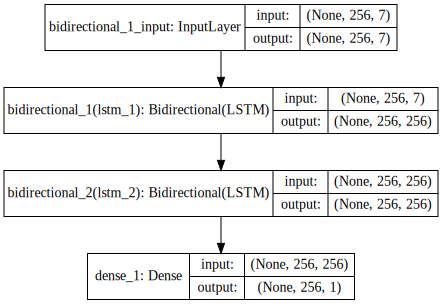

In [4]:
def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def create_model(l1=64, l2=64):
    np.random.seed(0)
    model = Sequential()
    model.add(Bidirectional(LSTM(l1, return_sequences=True), input_shape=(PREDICT_SIZE, 7)))
    model.add(Bidirectional(LSTM(l1, return_sequences=True)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy', r2])
    return model

model = create_model(128, 128)
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training

In [5]:
model = create_model(l1=128, l2=128)

history = History()
model.fit(train_x, train_y, epochs=10, batch_size=1024, verbose=2, 
          validation_data=(test_x, test_y), callbacks=[history])

Train on 34504 samples, validate on 8627 samples
Epoch 1/10
67s - loss: 0.0086 - acc: 0.0000e+00 - r2: 0.1698 - val_loss: 0.0015 - val_acc: 2.3047e-04 - val_r2: 0.8118
Epoch 2/10
64s - loss: 0.0010 - acc: 0.0000e+00 - r2: 0.8985 - val_loss: 7.0772e-04 - val_acc: 2.3092e-04 - val_r2: 0.9247
Epoch 3/10
64s - loss: 5.1159e-04 - acc: 0.0000e+00 - r2: 0.9505 - val_loss: 4.7124e-04 - val_acc: 2.3092e-04 - val_r2: 0.9518
Epoch 4/10
63s - loss: 4.0401e-04 - acc: 0.0000e+00 - r2: 0.9609 - val_loss: 4.0657e-04 - val_acc: 2.3138e-04 - val_r2: 0.9586
Epoch 5/10
64s - loss: 3.6323e-04 - acc: 0.0000e+00 - r2: 0.9648 - val_loss: 3.6897e-04 - val_acc: 2.3138e-04 - val_r2: 0.9625
Epoch 6/10
64s - loss: 3.3272e-04 - acc: 0.0000e+00 - r2: 0.9678 - val_loss: 3.3710e-04 - val_acc: 2.3183e-04 - val_r2: 0.9658
Epoch 7/10
64s - loss: 3.0541e-04 - acc: 0.0000e+00 - r2: 0.9704 - val_loss: 3.0790e-04 - val_acc: 2.3183e-04 - val_r2: 0.9688
Epoch 8/10
64s - loss: 2.7987e-04 - acc: 0.0000e+00 - r2: 0.9729 - val_los

In [8]:
%time eval_results = model.evaluate(test_x, test_y, batch_size=BATCH_SIZE, verbose=2)

for k, v in zip(model.metrics_names, eval_results):
    print(f'{k}: {v}')

CPU times: user 6.21 s, sys: 500 ms, total: 6.71 s
Wall time: 5.82 s
loss: 0.00022824506299551096
acc: 0.0002318303002202388
r2: 0.9747192473708374


[7812] r^2: 0.9864      
[6862] r^2: 0.9662      
[4216] r^2: 0.9396      
[8502] r^2: 0.8715      
[4643] r^2: 0.9589      
[6253] r^2: 0.9904      
[5739] r^2: 0.9549      
[3151] r^2: 0.9661      
[1284] r^2: 0.7826      
[2360] r^2: 0.9748      
[7702] r^2: 0.9763      
[2554] r^2: 0.9192      
[7927] r^2: 0.7689      
[1085] r^2: 0.9796      
[6453] r^2: 0.7061      
[7493] r^2: 0.9803      


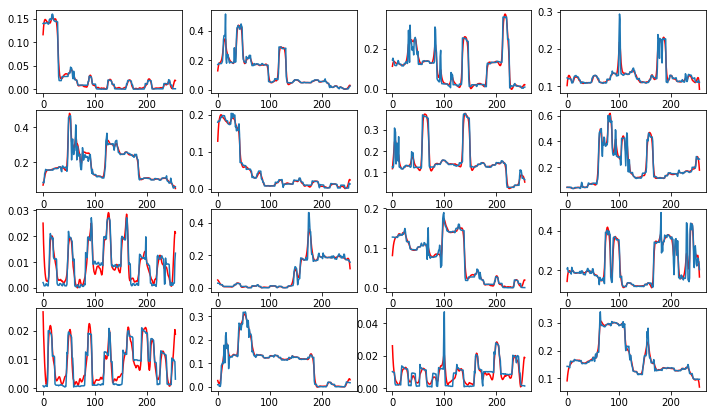

In [7]:
def vis_evaluate(model, test_x, test_y):
    n = len(test_x)
    
    fig, plots = subplots(4, 4)
    plots = plots.reshape(-1)
    
    fig.set_figwidth(12)
    fig.set_figheight(7)
    
    for p in plots:
        idx = np.random.randint(0, n)
        true_y = test_y[idx]
        pred_y = model.predict(test_x[idx:idx+1])
        
        score = r2_score(true_y.reshape(-1), pred_y.reshape(-1))
        print(f'[{idx:<4}] r^2: {score:<12.4}')  
        p.plot(pred_y[0], color='red')
        p.plot(true_y)

vis_evaluate(model, test_x, test_y)